In [45]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [46]:
# Create list of all targets (minus background noise)
dataset_path = '../google_speech_data_v1'
original_labels = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
original_labels.remove('_background_noise_')
print(original_labels)

['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'off', 'four']


In [47]:
# Settings
feature_sets_path = './'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'my_model'
#wake_word = 'stop'
# Define target words
target_words = ['up', 'down', 'left', 'right', 'go', 'stop']

In [48]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [49]:
def filter_data(x, y, target_words, all_labels):
    # Convert labels to integers
    y = y.astype(int)

    # Find the indices of the target words in the full label set
    target_indices = [all_labels.index(word) for word in target_words]

    # Filter the dataset to include only target indices
    filtered_indices = np.isin(y, target_indices)
    x_filtered = x[filtered_indices]
    y_filtered = y[filtered_indices]

    # Map the filtered labels to new indices (0 to len(target_words)-1)
    y_mapped = np.array([target_words.index(all_labels[label]) for label in y_filtered])
    
    #CHECK
    #print("Filtered Labels (y_filtered):", y_filtered)
    #print("Target Indices:", target_indices)
    #print("Mapped Labels (y_mapped):", y_mapped)

    return x_filtered, y_mapped



# Assuming you have `original_labels` from the dataset
original_labels = ['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 
                   'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 
                   'up', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'off', 
                   'four']

# Apply filter to training, validation, and test sets
x_train, y_train = filter_data(x_train, y_train, target_words, original_labels)
x_val, y_val = filter_data(x_val, y_val, target_words, original_labels)
x_test, y_test = filter_data(x_test, y_test, target_words, original_labels)

# One-hot encode labels
num_classes = len(target_words)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [50]:


print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

x_val shape: (1322, 16, 16)
x_test shape: (1273, 16, 16)


In [ ]:
# Define the model architecture
model = models.Sequential([
    layers.Input(shape=(x_train.shape[1], x_train.shape[2], 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Multiclass output
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # For multiclass classification
              metrics=['accuracy'])


In [53]:
# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,  # Adjust based on your needs
    batch_size=32
)

Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8514 - loss: 0.4250 - val_accuracy: 0.8495 - val_loss: 0.4390
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8759 - loss: 0.3537 - val_accuracy: 0.8593 - val_loss: 0.3955
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9053 - loss: 0.2780 - val_accuracy: 0.8790 - val_loss: 0.3583
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9164 - loss: 0.2350 - val_accuracy: 0.8775 - val_loss: 0.3529
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9270 - loss: 0.2061 - val_accuracy: 0.8865 - val_loss: 0.3383
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9395 - loss: 0.1753 - val_accuracy: 0.8896 - val_loss: 0.3529
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9447 - loss: 0.1560 - val_accuracy: 0.8971 - val_loss: 0.3215
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9562 - loss: 0.1273 - val_accuracy: 0.

In [54]:
# Display model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,460 (615.08 KB)

 Trainable params: 52,486 (205.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,974 (410.06 KB)

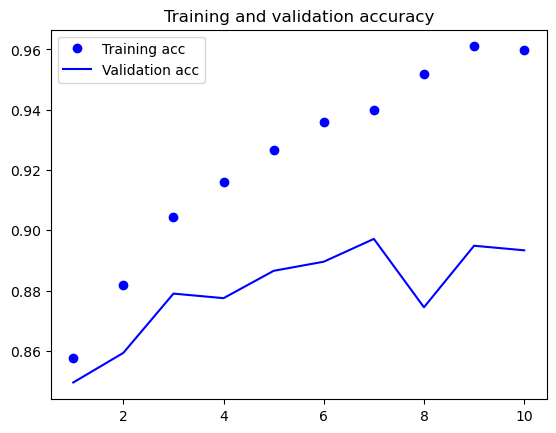

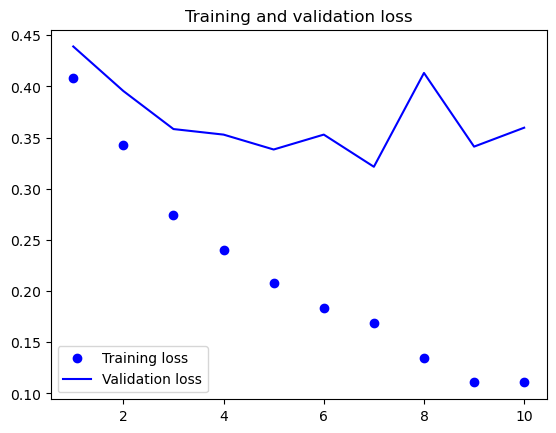

In [57]:
# Plot results
import matplotlib.pyplot as plt
history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9091 - loss: 0.2751


[0.31208834052085876, 0.9010211825370789]

In [59]:
# Export model for Tensorflow lite conversion
filepath = 'target_words_model'
model.export(filepath)

INFO:tensorflow:Assets written to: target_words_model/assets


INFO:tensorflow:Assets written to: target_words_model/assets


Saved artifact at 'target_words_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 16, 1), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  5339368528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5339367952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5116357008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5339367184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5339368144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5339372368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5322352848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5322358224: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [60]:
# Parameters
keras_model_filename = 'target_words_model.h5'
tflite_filename = 'target_words_stop_lite.tflite'
# Convert model to TF Lite model
#model = models.load_model(keras_model_filename)
converter = tf.lite.TFLiteConverter.from_saved_model(filepath)
tflite_model = converter.convert()
open(tflite_filename, 'wb').write(tflite_model)

W0000 00:00:1733797390.250964  734241 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1733797390.270162  734241 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-12-09 21:23:10.302497: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: target_words_model
2024-12-09 21:23:10.303426: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-12-09 21:23:10.303441: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: target_words_model
2024-12-09 21:23:10.368877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-12-09 21:23:10.370000: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-12-09 21:23:10.841963: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: target_words_model
2024-12-09 21:23:10.855663: I tensorflow/cc/saved_model/loa

213344